# Analyse trends

The main goal here is to extract keywords used to quantify good and bad beers, for different time periods. The idea will then be to look if these words change over time, which could mean that people are not judging beers based on the same criterias anymore.

## Importing modules and custom functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from load_reviews import load_reviews

try:
    import wordcloud
except ModuleNotFoundError:
    %pip install wordcloud
    import wordcloud

## Importing some reviews

In [2]:
reviews = load_reviews("../dataset/BeerAdvocate/reviews.txt", max_entries=100000).dropna()
display(reviews)

Loading reviews from ../dataset/BeerAdvocate/reviews.txt
Number of lines: 44022962


  4%|▍         | 1699998/44022962 [00:01<00:27, 1549785.73it/s]


,beer_id,user_id,date,overall,rating,text
26272,306,beeradvocate.1,8.854668e+08,1.00,1.60,Presentation: 12oz. green bottle.Appearance: B...
26684,305,beeradvocate.1,8.880588e+08,4.00,3.95,Presentation: 12oz. clear bottle (wide w/thin ...
68137,19,todd.2,8.889228e+08,4.00,4.48,Presentation: Highly prestigious looking label...
16497,79,beeradvocate.1,8.907372e+08,4.50,4.35,Presentation: Impressive wide 500ml brown bott...
26475,304,beeradvocate.1,8.921160e+08,4.00,4.03,Presentation: 12oz. clear bottle (wide w/thin ...
...,...,...,...,...,...,...
82020,108464,vinicole.65585,1.500890e+09,3.75,3.78,Gravity - Brackley Beer Festival 2017.Labelled...
2614,47581,the_kriek_freak.848244,1.500890e+09,4.50,4.51,This is one insanely tasty beer. It pours jet ...
80382,811,emh73.1043324,1.500890e+09,3.25,3.37,Pours a clear Amber with a one inch white head...
44673,218932,jazzyjeff13.522501,1.500890e+09,3.25,3.45,A 330ml bottle with a BB of Nov 2017. Purchase...


## Extracting a list of users and their number of reviews

This will allow us to look at the most active users only.

In [3]:
dummy = reviews.groupby("user_id").count().sort_values(by="rating", ascending=False)
user_ids = dummy.index.values
user_counts = dummy["rating"].values

# Print the top 10 users
for i in range(10):
    print(f"{user_ids[i]} has {user_counts[i]} reviews")

blackhaddock.90923 has 1569 reviews
wl0307.16869 has 1528 reviews
emperorbevis.621888 has 1324 reviews
jazzyjeff13.522501 has 1026 reviews
stjamesgate.163714 has 734 reviews
flyingpig.524986 has 628 reviews
vinicole.65585 has 603 reviews
cwrwambyth.557249 has 441 reviews
mdagnew.19527 has 422 reviews
bark.4217 has 361 reviews


## Making some plots

In the following, we will make 4 plots, for the most active user only:
* The most used reviews for a "good beer" tested long ago
* The most used reviews for a "good beer" tested recently
* The most used reviews for a "bad beer" tested long ago
* The most used reviews for a "bad beer" tested recently

Text(0.5, 1.0, 'Poor reviews (<3.0), recent (based on 82 reviews)')

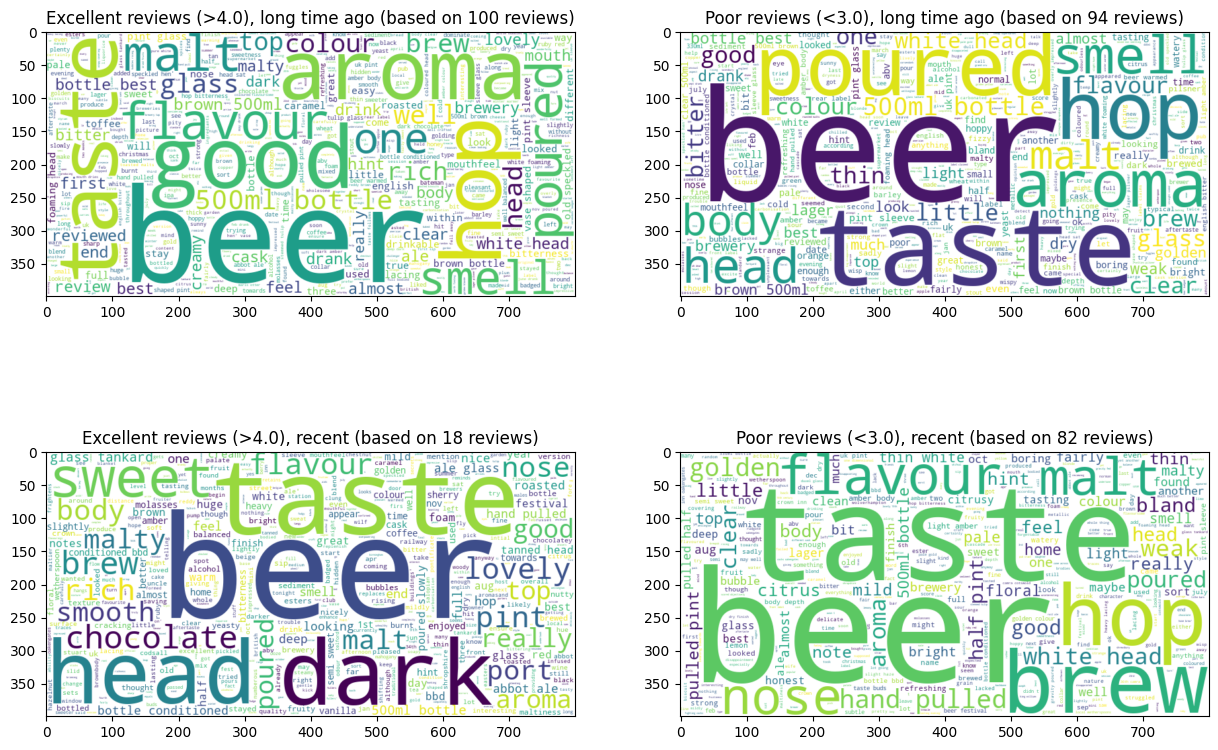

In [4]:
rating_quantiles = np.quantile(
    a=reviews.query("user_id == @user_ids[0]")["overall"].values,
    q=[0.25, 0.75]
)

date_quantiles = np.quantile(
    a=reviews.query("user_id == @user_ids[0]")["date"].values,
    q=[0.5]
)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

reviews_subset = reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date < @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(texts)
axes[0, 0].imshow(wc, interpolation="bilinear")
axes[0, 0].set_title(f"Excellent reviews (>{rating_quantiles[1]}), long time ago (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall < @rating_quantiles[0] & date < @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(texts)
axes[0, 1].imshow(wc, interpolation="bilinear")
axes[0, 1].set_title(f"Poor reviews (<{rating_quantiles[0]}), long time ago (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall > @rating_quantiles[1] & date > @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(texts)
axes[1, 0].imshow(wc, interpolation="bilinear")
axes[1, 0].set_title(f"Excellent reviews (>{rating_quantiles[1]}), recent (based on {len(reviews_subset)} reviews)")

reviews_subset = reviews.query("user_id == @user_ids[0] & overall < @rating_quantiles[0] & date > @date_quantiles[0]").copy()
texts = " ".join(reviews_subset["text"].values).lower()
wc = wordcloud.WordCloud(background_color="white", max_words=1000, width=800, height=400).generate(texts)
axes[1, 1].imshow(wc, interpolation="bilinear")
axes[1, 1].set_title(f"Poor reviews (<{rating_quantiles[0]}), recent (based on {len(reviews_subset)} reviews)")

## Go further

To see if there is a real **evolution** in the trends, or if the differences among the plots above is only due to random fluctuations, we could imagine looking at the frequency of some specific words over time.

![](word_evolution_good.png)

![](word_evolution_bad.png)